In [74]:
#setup
data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BSBSSSBB'
meas='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [75]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [76]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [77]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-4-da1c4f2f274c>:4 

## Read Statistics File

In [78]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [79]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+-----------+-----------+------+--------------------+------+
| 951.3156042742843|-36.86447687289478|-232.83629691576016|     46.9|BSBSSSBB| 31.0833| -82.5653|       TOBS| 0.4872809225033287| 0.4865110011103735| 0.4557973389173408|0.19826879475154144|USC00095492|  8902570.0|     0|[80 54 38 59 40 C...|2011.0|
| 86

### Plot Mean and Eigenvecs

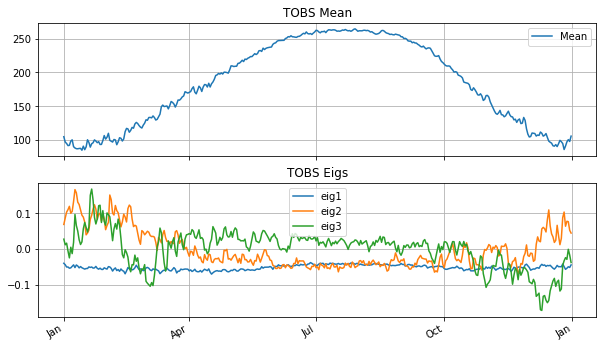

In [80]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

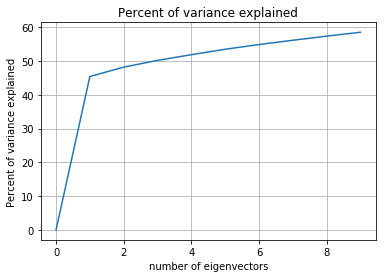

In [81]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [82]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

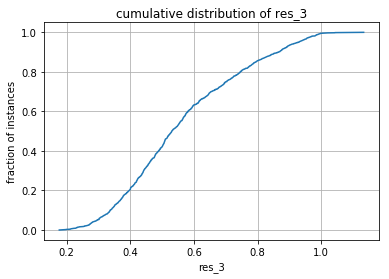

In [83]:
plot_CDF(df,'res_3')

In [84]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00095492', 2011.0)

In [85]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

40880

In [86]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [87]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [88]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00094238 1095
USC00098351 1762
USW00093845 1448
USC00094255 364
USC00094429 18465
USC00092839 29409
USC00095858 342
USC00095811 9764
USC00090670 2885
USC00096255 728
USC00098476 14860
USC00095696 1442
USC00093325 6005
USC00094110 3619
USC00095401 336
USC00095874 20730
USC00097777 15617
USC00093312 707
USC00096237 7167
USC00099020 365
USC00092865 2186
USC00089640 357
USC00094862 2470
USC00084393 2542
USC00099451 1086
USC00093386 20622
USC00090131 8468
USC00092966 21720
USC00092844 726
USC00097171 4358
USC00094170 28119
USC00090010 2125
USC00099186 27541
USC00093465 16820
USC00094971 1094
USC00094594 12141
USC00094204 9380
USC00095386 9976
USC00096244 3243
USC00084731 29542
USC00098974 10452
USC00090090 3460
USC00095863 6518
USC00085275 28957
USC00098972 4371
USC00084394 19786
USC00092783 20352
USC00095492 730
USC00098496 9222
USC00085099 19453
USC00096650 730
USW00013861 2189
USC00083470 22256
USC00095314 23227


In [89]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(54, 40880)


In [90]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  203.171356213
RMS removing mean-by-station=  81.5408358551
RMS removing mean-by-day   =  45.6835640248


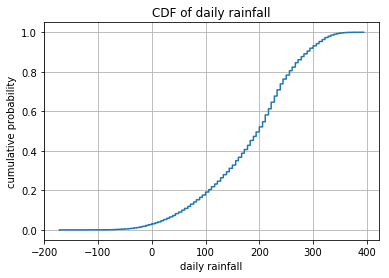

In [91]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [92]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [138]:
#USC00193270 21482
#USC00193702 28237
#USC00094238 1424
#USC00098351 3393
X=copy(All['USC00092783'])
Y=copy(All['USC00098351'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


20352
1762
365
365


In [155]:
constant_val = 250.0
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>constant_val
    YG=Y[G]>constant_val
    
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

m=0,l=0,n1=0,n2=0,LogPval=nan
(nan, 0)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


### calculate the normalized log probability for each pair of stations.

In [156]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j:
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 m=693,l=195,n1=262,n2=239,LogPval=-0.227411
m=12667,l=1730,n1=2375,n2=2037,LogPval=-0.222613
m=18385,l=2880,n1=4102,n2=4357,LogPval=-0.153573
m=11940,l=1674,n1=2205,n2=5528,LogPval=-0.041441
m=18913,l=1781,n1=5136,n2=3501,LogPval=-0.029767
m=355,l=3,n1=9,n2=17,LogPval=-0.014390
m=1713,l=3,n1=34,n2=12,LogPval=-0.003864
m=2740,l=246,n1=987,n2=570,LogPval=-0.004041
m=5975,l=195,n1=2595,n2=352,LogPval=-0.002327
m=2462,l=23,n1=47,n2=191,LogPval=-0.012748
m=12457,l=432,n1=2216,n2=575,LogPval=-0.039112
m=17134,l=2075,n1=4392,n2=2913,LogPval=-0.098469
m=708,l=3,n1=24,n2=21,LogPval=-0.005137
m=0,l=0,n1=0,n2=0,LogPval=nan
m=14541,l=1037,n1=3036,n2=1325,LogPval=-0.078713
m=696,l=56,n1=166,n2=144,LogPval=-0.018622
m=4848,l=42,n1=108,n2=309,LogPval=-0.010837
m=11009,l=2149,n1=2958,n2=2686,LogPval=-0.219111
m=11612,l=1505,n1=1856,n2=5571,LogPval=-0.044468
m=0,l=0,n1=0,n2=0,LogPval=nan
m=19148,l=2321,n1=5027,n2=3021,LogPval=-0.109484
m=6733,l=244,n1=338,n2=1158,LogPval=-0.040142
m=0,l=0,n1=0,n2=0,L

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


m=357,l=2,n1=17,n2=4,LogPval=-0.012441
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=8,n1=17,n2=28,LogPval=-0.033131
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=17,n1=17,n2=208,LogPval=-0.026522
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=5,n1=17,n2=14,LogPval=-0.023968
m=355,l=8,n1=17,n2=44,LogPval=-0.023097
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=350,l=0,n1=17,n2=1,LogPval=-0.000142
m=0,l=0,n1=0,n2=0,LogPval=nan
m=351,l=6,n1=16,n2=27,LogPval=-0.021632
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=6,n1=17,n2=22,LogPval=-0.023872
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=1,n1=17,n2=4,LogPval=-0.005032
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=8,n1=17,n2=30,LogPval=-0.031513
m=357,l=1,n1=17,n2=6,LogPval=-0.004157
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=357,l=1,n1=17,n2=2,LogPval=-0.006715
m=353,l=2,n1=17,n2=8,LogPval=-0.008657
m=0,

m=16621,l=1184,n1=1315,n2=5314,LogPval=-0.064239
m=7819,l=181,n1=735,n2=281,LogPval=-0.035523
m=335,l=1,n1=2,n2=31,LogPval=-0.005317
m=0,l=0,n1=0,n2=0,LogPval=nan
m=363,l=5,n1=7,n2=34,LogPval=-0.025469
m=7552,l=165,n1=177,n2=3364,LogPval=-0.013346
m=0,l=0,n1=0,n2=0,LogPval=nan
m=4308,l=30,n1=34,n2=1490,LogPval=-0.005332
m=14915,l=67,n1=887,n2=102,LogPval=-0.008742
m=5727,l=37,n1=38,n2=2559,LogPval=-0.004697
m=2856,l=37,n1=39,n2=1279,LogPval=-0.008603
m=0,l=0,n1=0,n2=0,LogPval=nan
m=719,l=3,n1=4,n2=22,LogPval=-0.012849
m=2144,l=2,n1=13,n2=13,LogPval=-0.002794
m=11953,l=104,n1=195,n2=1916,LogPval=-0.006366
m=1392,l=314,n1=434,n2=401,LogPval=-0.208886
m=10852,l=86,n1=90,n2=4751,LogPval=-0.005436
m=6722,l=169,n1=180,n2=2666,LogPval=-0.018681
m=3263,l=20,n1=21,n2=1487,LogPval=-0.004090
m=6472,l=583,n1=848,n2=1750,LogPval=-0.059068
m=0,l=0,n1=0,n2=0,LogPval=nan
m=21242,l=2618,n1=3227,n2=3724,LogPval=-0.195069
m=1079,l=0,n1=4,n2=2,LogPval=-0.000007
m=1823,l=8,n1=11,n2=92,LogPval=-0.010546
m=3

m=1404,l=6,n1=623,n2=7,LogPval=-0.002511
20 m=0,l=0,n1=0,n2=0,LogPval=nan
m=1426,l=316,n1=392,n2=528,LogPval=-0.157912
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1443,l=119,n1=316,n2=203,LogPval=-0.055860
m=0,l=0,n1=0,n2=0,LogPval=nan
m=348,l=19,n1=83,n2=35,LogPval=-0.029870
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1820,l=391,n1=449,n2=587,LogPval=-0.226091
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1749,l=258,n1=432,n2=342,LogPval=-0.150498
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1423,l=156,n1=316,n2=215,LogPval=-0.110556
m=0,l=0,n1=0,n2=0,LogPval=nan
m=729,l=155,n1=170,n2=270,LogPval=-0.202477
m=363,l=44,n1=83,n2=54,LogPval=-0.148212
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=142

m=2466,l=4,n1=101,n2=15,LogPval=-0.002459
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
28 m=1051,l=4,n1=8,n2=26,LogPval=-0.010343
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1094,l=1,n1=8,n2=2,LogPval=-0.003868
m=1093,l=5,n1=8,n2=118,LogPval=-0.006872
m=1066,l=7,n1=8,n2=582,LogPval=-0.002773
m=724,l=1,n1=2,n2=30,LogPval=-0.003496
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1054,l=2,n1=8,n2=6,LogPval=-0.006840
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1094,l=0,n1=8,n2=3,LogPval=-0.000020
m=1082,l=0,n1=8,n2=6,LogPval=-0.000041
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1092,l=2,n1=8,n2=6,LogPval=-0.006666
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1066,l=4,n1=8,n2=73,LogPval=-0.006401
m=716,l=0,n1=6,n2=10,LogPval=-0.000118
m=1086,l=8,n1=8,n2=613,LogPval=-0.004231
m=0,l=0,n1=0,n2=0,LogPval=nan
m=716,l=2,n1=7,n2=12,LogPval=-0.007387
m=1090,l=6,n1=8,n2=87,LogPval=-0.011150
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1

m=357,l=8,n1=30,n2=17,LogPval=-0.031513
m=0,l=0,n1=0,n2=0,LogPval=nan
m=687,l=190,n1=228,n2=275,LogPval=-0.206682
m=4214,l=638,n1=1475,n2=793,LogPval=-0.103539
m=1081,l=32,n1=51,n2=106,LogPval=-0.045296
m=5430,l=42,n1=1550,n2=66,LogPval=-0.003680
m=4308,l=30,n1=1490,n2=34,LogPval=-0.005332
m=363,l=7,n1=14,n2=13,LogPval=-0.047407
m=0,l=0,n1=0,n2=0,LogPval=nan
m=5427,l=281,n1=1537,n2=323,LogPval=-0.048671
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1071,l=23,n1=48,n2=86,LogPval=-0.029422
m=5407,l=1766,n1=1854,n2=2422,LogPval=-0.308399
m=6086,l=1457,n1=1754,n2=2621,LogPval=-0.138741
m=0,l=0,n1=0,n2=0,LogPval=nan
m=5730,l=534,n1=1606,n2=677,LogPval=-0.077113
m=1091,l=37,n1=51,n2=96,LogPval=-0.064409
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=5362,l=1228,n1=1509,n2=1678,LogPval=-0.227701
m=2476,l=810,n1=895,n2=1006,LogPval=-0.323719
m=700,l=14,n1=36,n2=35,LogPval=-0.033523
m=0,l=0,n1=0,n2=0,LogPval=nan
m=5752,l=1381,n1=1663,n2=1615,LogPval=-0.306689
m=3914,l=48,n1=1353,n2=61,LogPval=

m=0,l=0,n1=0,n2=0,LogPval=nan
m=1017,l=147,n1=279,n2=207,LogPval=-0.113374
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1397,l=220,n1=425,n2=281,LogPval=-0.129992
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=365,l=47,n1=119,n2=51,LogPval=-0.133579
m=1392,l=314,n1=401,n2=434,LogPval=-0.208886
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=678,l=109,n1=216,n2=138,LogPval=-0.127922
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1762,l=327,n1=525,n2=438,LogPval=-0.152923
m=1043,l=239,n1=319,n2=338,LogPval=-0.183049
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan

m=2187,l=118,n1=119,n2=1027,LogPval=-0.040591
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1036,l=36,n1=37,n2=425,LogPval=-0.028831
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1824,l=2,n1=92,n2=10,LogPval=-0.001417
m=1823,l=8,n1=92,n2=11,LogPval=-0.010546
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1459,l=39,n1=87,n2=206,LogPval=-0.019474
m=0,l=0,n1=0,n2=0,LogPval=nan
m=338,l=7,n1=18,n2=18,LogPval=-0.034956
m=1448,l=19,n1=105,n2=39,LogPval=-0.019174
m=1740,l=88,n1=90,n2=820,LogPval=-0.035453
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1808,l=18,n1=100,n2=50,LogPval=-0.013628
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=2178,l=116,n1=119,n2=835,LogPval=-0.048322
m=1427,l=57,n1=61,n2=636,LogPval=-0.025615
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval=nan
m=1824,l=91,n1=92,n2=741,LogPval=-0.044629
m=1083,l=4,n1=51,n2=13,LogPval=-0.005695
m=0,l=0,n1=0,n2=0,LogPval=nan
m=0,l=0,n1=0,n2=0,LogPval

In [157]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[   0.  693.]
 [ 693.    0.]]
[[-0.4        -0.22741126]
 [-0.22741126 -0.4       ]]


(2916,) (1692,)


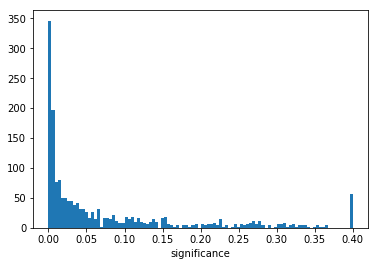

In [158]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')

In [159]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

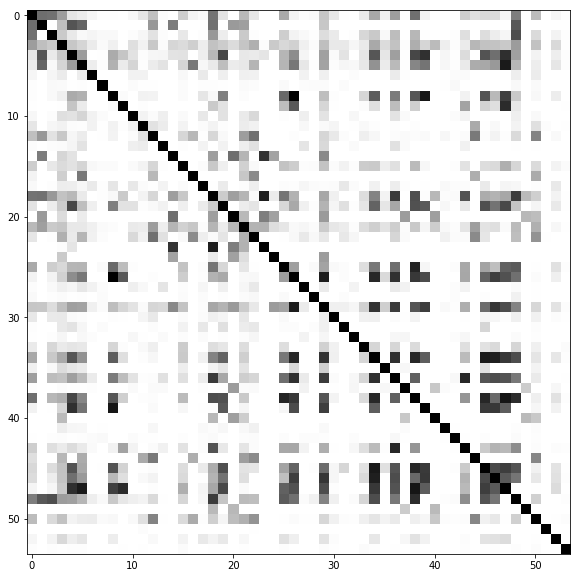

In [160]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [154]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USC00094238', u'USC00098351', u'USW00093845', u'USC00094255', u'USC00094429', u'USC00092839', u'USC00095858', u'USC00095811']


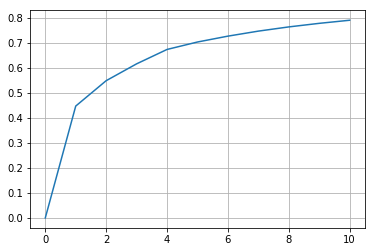

In [161]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [131]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

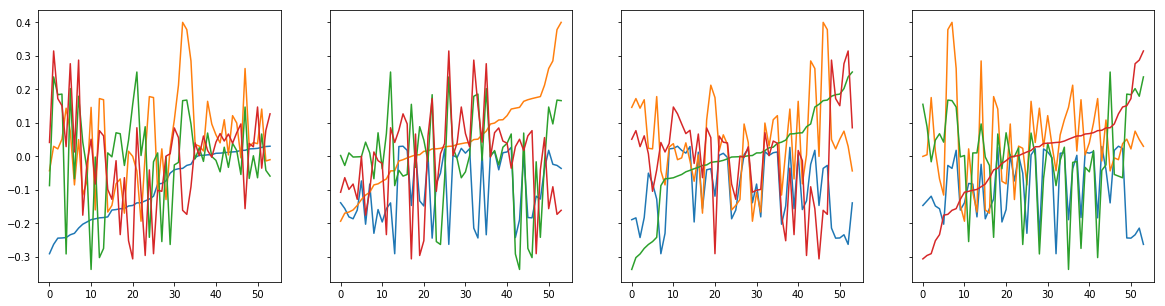

In [132]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [162]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

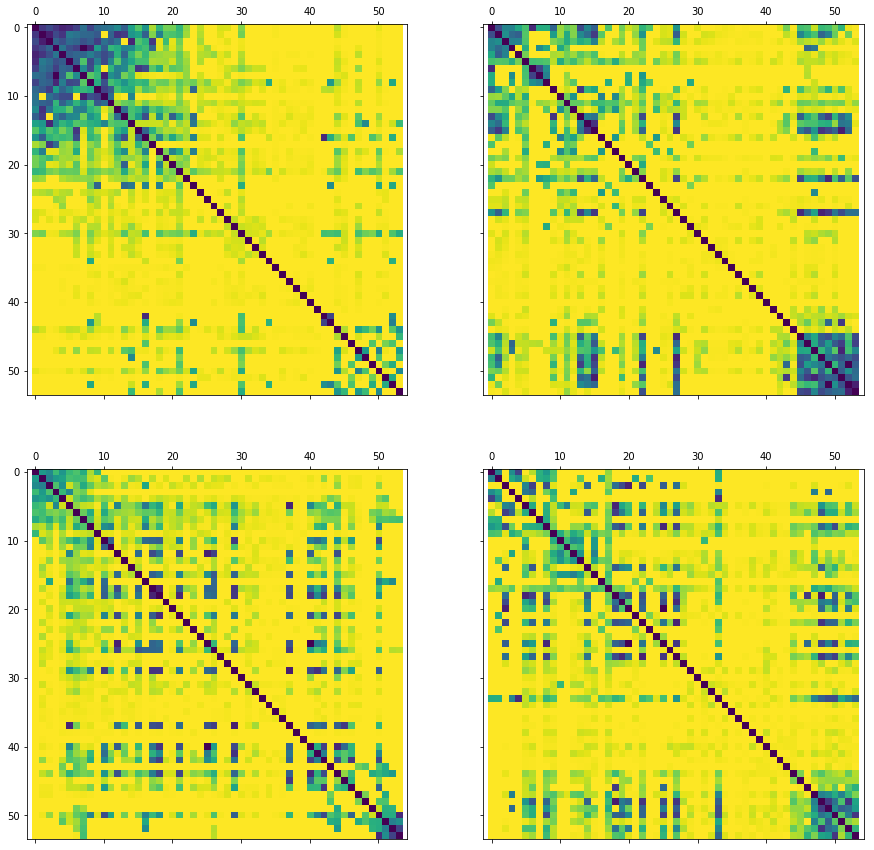

In [163]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        axes[r,c].matshow(P_norm_reord)
        i+=1

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [164]:
from pickle import dump
with open(data_dir+'/'+ meas+'_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    